## Experimento No 5 - Different Preprocessing

### Load data and import libraries

In [1]:
# In case you're running this in colab
# !pip install pycaret
# !pip install dython
# !pip install optuna

In [27]:
# Data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Modeling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier

# Evaluation
from sklearn.model_selection import cross_val_score

# Hyper-parameter tuning
import optuna

# Configurations
RANDOM_SEED = 42 # For reproducibility

sns.set_palette('pastel')
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)

In [3]:
df_train_full = pd.read_csv('data/train.csv')
df_test_full = pd.read_csv('data/test.csv')
df_train_full.head().T

,0,1,2,3,4
ID,904256,645256,308367,470353,989032
PERIODO,20212,20212,20203,20195,20212
ESTU_PRGM_ACADEMICO,ENFERMERIA,DERECHO,MERCADEO Y PUBLICIDAD,ADMINISTRACION DE EMPRESAS,PSICOLOGIA
ESTU_PRGM_DEPARTAMENTO,BOGOTÁ,ATLANTICO,BOGOTÁ,SANTANDER,ANTIOQUIA
ESTU_VALORMATRICULAUNIVERSIDAD,Entre 5.5 millones y menos de 7 millones,Entre 2.5 millones y menos de 4 millones,Entre 2.5 millones y menos de 4 millones,Entre 4 millones y menos de 5.5 millones,Entre 2.5 millones y menos de 4 millones
ESTU_HORASSEMANATRABAJA,Menos de 10 horas,0,Más de 30 horas,0,Entre 21 y 30 horas
FAMI_ESTRATOVIVIENDA,Estrato 3,Estrato 3,Estrato 3,Estrato 4,Estrato 3
FAMI_TIENEINTERNET,Si,No,Si,Si,Si
FAMI_EDUCACIONPADRE,Técnica o tecnológica incompleta,Técnica o tecnológica completa,Secundaria (Bachillerato) completa,No sabe,Primaria completa
FAMI_TIENELAVADORA,Si,Si,Si,Si,Si


In [4]:
df_analysis = df_train_full.copy()

In [5]:
df_analysis.isna().sum().sort_values(ascending=False)

FAMI_TIENEAUTOMOVIL               43623
FAMI_TIENELAVADORA                39773
FAMI_TIENECOMPUTADOR              38103
FAMI_ESTRATOVIVIENDA              32137
ESTU_HORASSEMANATRABAJA           30857
FAMI_TIENEINTERNET.1              26629
FAMI_TIENEINTERNET                26629
FAMI_EDUCACIONMADRE               23664
FAMI_EDUCACIONPADRE               23178
ESTU_PAGOMATRICULAPROPIO           6498
ESTU_VALORMATRICULAUNIVERSIDAD     6287
ID                                    0
ESTU_PRIVADO_LIBERTAD                 0
PERIODO                               0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_PRGM_ACADEMICO                   0
RENDIMIENTO_GLOBAL                    0
dtype: int64

<Axes: xlabel='FAMI_EDUCACIONPADRE', ylabel='count'>

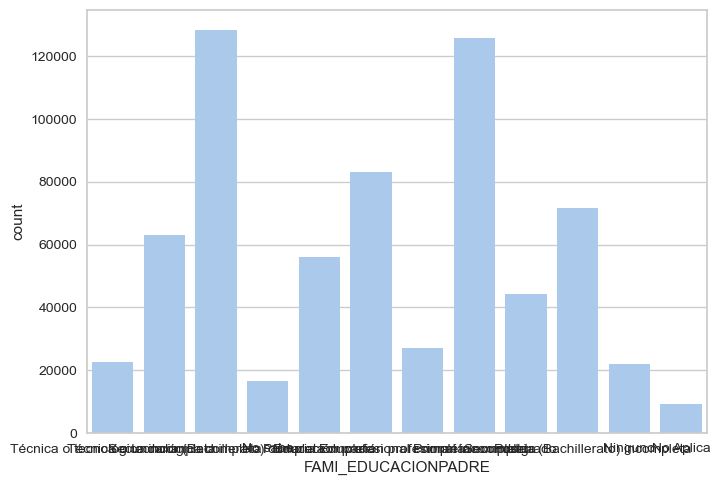

In [6]:
sns.countplot(df_analysis, x='FAMI_EDUCACIONPADRE')

### Preprocessing

In [7]:
def normalize_text(text: str):
    """Removes any weird character like accents from a string"""
    import unicodedata

    if not pd.isna(text):
        return (
            unicodedata.normalize('NFKD', text)
            .encode('ASCII', 'ignore')
            .decode('utf-8')
        )
    return text

def clean_data(df: pd.DataFrame) -> pd.DataFrame: 
    new_df = df.copy() # Create a copy

    # Drop and clean columns
    new_df.drop(['ID', 'FAMI_TIENEINTERNET.1', 'ESTU_PRIVADO_LIBERTAD'], axis=1, inplace=True)

    # Change data types
    new_df['PERIODO'] = new_df['PERIODO'].astype(str)
    
    # Remove weird characters from values
    for col in ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
        new_df[col] = new_df[col].apply(normalize_text)

    # Replace values to make more sense
    new_df['ESTU_HORASSEMANATRABAJA'].replace('0', 'No trabaja', inplace=True)
    new_df['FAMI_EDUCACIONPADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)
    new_df['FAMI_EDUCACIONMADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)

    return new_df

def impute_cols(df: pd.DataFrame):
    new_df = df.copy() # Make a copy

    # Impute with own values
    new_df['FAMI_ESTRATOVIVIENDA'] = new_df['FAMI_ESTRATOVIVIENDA'].fillna('Unknown') # 'Sin Estrato' or mode or 'Unknown'
    new_df['ESTU_HORASSEMANATRABAJA'] = new_df['ESTU_HORASSEMANATRABAJA'].fillna('No trabaja') # No trabaja or Unknown
    new_df['FAMI_EDUCACIONPADRE'] = new_df['FAMI_EDUCACIONPADRE'].fillna('Ninguno') # Same as with MADRE
    new_df['FAMI_EDUCACIONMADRE'] = new_df['FAMI_EDUCACIONMADRE'].fillna('Ninguno') # Otra opcion: Ninguno or Unknown
 
    # Select binary columns
    # For VALORMATRICULA values could be 'No pago matricula' or Mode or Unknown (We'll go we the mode first)
    binary_cols = [col for col in new_df.columns if new_df[col].nunique() == 2]
    for col in binary_cols + ['ESTU_VALORMATRICULAUNIVERSIDAD']:
        col_mode = new_df[col].mode()[0]
        new_df[col] = new_df[col].fillna(col_mode)

    return new_df

In [8]:
# Clean the training and testing datasets
df_train = clean_data(df_train_full)
df_test = clean_data(df_test_full)

In [9]:
# Impute values in training and testing datasets
df_train = impute_cols(df_train)
df_test = impute_cols(df_test)

In [10]:
df_train.shape

(692500, 14)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   PERIODO                         692500 non-null  object
 1   ESTU_PRGM_ACADEMICO             692500 non-null  object
 2   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object
 3   ESTU_VALORMATRICULAUNIVERSIDAD  692500 non-null  object
 4   ESTU_HORASSEMANATRABAJA         692500 non-null  object
 5   FAMI_ESTRATOVIVIENDA            692500 non-null  object
 6   FAMI_TIENEINTERNET              692500 non-null  object
 7   FAMI_EDUCACIONPADRE             692500 non-null  object
 8   FAMI_TIENELAVADORA              692500 non-null  object
 9   FAMI_TIENEAUTOMOVIL             692500 non-null  object
 10  ESTU_PAGOMATRICULAPROPIO        692500 non-null  object
 11  FAMI_TIENECOMPUTADOR            692500 non-null  object
 12  FAMI_EDUCACIONMADRE           

#### Encoding

In [12]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame():
    """
    Turns features into numeric values applying an encoding for each
    column.
    """
    df = df.copy() # Make copy

    # Ordinal encoding
    ord_encoder = OrdinalEncoder() # Ordinal Encoder
    ord_cols = ['FAMI_ESTRATOVIVIENDA','ESTU_PRGM_DEPARTAMENTO']    
    df_ordinal = pd.DataFrame(ord_encoder.fit_transform(df[ord_cols]), columns=ord_cols)
    
    for col in ord_cols:
        max_val = df_ordinal[col].max()
        df_ordinal[col] = df_ordinal[col].map(lambda x: x / max_val) # Normalize values 0 - 1

    df = pd.concat([df.drop(ord_cols, axis=1), df_ordinal], axis=1)

    # Binary encoding
    bin_cols = [col for col in df.columns if df[col].nunique() == 2]

    for col in bin_cols:
        df[col] = df[col].replace({'Si': 1, 'No': 0})

    # Label encoding if training data
    if 'RENDIMIENTO_GLOBAL' in df.columns:
        label_encoder = LabelEncoder() # Label encoder
        target = 'RENDIMIENTO_GLOBAL'
        # Encode labels
        new_labels = pd.DataFrame(label_encoder.fit_transform(df[target]), columns=[target])
        # Join new encoded labels
        df = pd.concat([df.drop('RENDIMIENTO_GLOBAL', axis=1), new_labels], axis=1)

    # One-hot encoding
    df = pd.get_dummies(df, dtype=int)

    
    return df

In [13]:
# Encode features and target (for training dataset)
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

In [14]:
df_train.head()

,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_ESTRATOVIVIENDA,ESTU_PRGM_DEPARTAMENTO,RENDIMIENTO_GLOBAL,PERIODO_20183,PERIODO_20184,...,FAMI_EDUCACIONMADRE_Educacion profesional completa,FAMI_EDUCACIONMADRE_Educacion profesional incompleta,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_Postgrado,FAMI_EDUCACIONMADRE_Primaria completa,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Tecnica o tecnologica completa,FAMI_EDUCACIONMADRE_Tecnica o tecnologica incompleta
0,1,1,1,0,1,0.285714,0.133333,2,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,1,0.285714,0.100000,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0.285714,0.133333,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,0,1,0.428571,0.866667,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,1,0,1,0.285714,0.033333,3,0,0,...,0,0,0,0,1,0,0,0,0,0


## Model Creation

At this point we are going to try a **XGBClassifier** to see how the preprocessing improve the accuracy



In [26]:
# Split training into features as target
X = df_train.drop('RENDIMIENTO_GLOBAL', axis=1)
y = df_train.RENDIMIENTO_GLOBAL

# Define model
model = XGBClassifier()

# Use cross validation to evaluate the model
scores = cross_val_score(model, X, y, cv = 5, scoring = 'accuracy')
print(scores)
print(f'Mean Accuracy: {np.mean(scores)}')

[0.42922744 0.42615884 0.4293213  0.42763899 0.42851986]
Mean Accuracy: 0.4281732851985559


## Hyper-parameters Tuning

In [30]:
def xgb_objective(trial):
    
    # Create params
    params = {
        'n_estimators': trial.suggest_int('n_est', 100, 1500),
        'learning_rate': trial.suggest_loguniform('lr', 1e-2, 0.1)
    }
    # Set params to the model and train the new model
    model = XGBClassifier(**params)

    # Calculate scores in 5 folds
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=10)

[I 2024-05-29 17:14:01,995] A new study created in memory with name: no-name-67a6a7e2-e3d0-49b2-8037-91120549ebfd


In [ ]:
best_params = study.best_params
best_params

## Making Predictions

In [24]:
# 'max_delta_step': trial.suggest_int('max_delta_step', 0, 20),
# 'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
# 'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1.0),
# 'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.1, 1.0)
# 'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
# 'max_depth': trial.suggest_int('max_depth', 1, 50)
# {'n_est': 1084, 'lr': 0.09930447154713608}